In [62]:
import sys
sys.path.append('/Users/gmaurer/GitHub/gc_ltreb/load')
import load_longterm as ld
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Important parent paths
#
ready_path = '/Users/gmaurer/GD_gmaurer@nmsu/_current/gc_ltreb_io/data/'
out_path = '/Users/gmaurer/GD_gmaurer@nmsu/_current/gc_ltreb_io/'

ltpath = '~/Dropbox/Repository Remodel Complete architecture/Sala Lab Projects/Projects Currently In Operation/Long Term/'
# The dropbox location of soil moisture files
#dropbox_path = os.path.expanduser('~/Dropbox/Repository Remodel Complete architecture/Sala Lab Projects/Projects Currently In Operation/Long Term/Soil_moisture_data/')
# An output path
#outpath = '/Users/gmaurer/GD_gmaurer@nmsu/_current/gc_ltreb_io/'
# Get treatments
trt = pd.read_csv(os.path.join(ltpath, 'lt_plot_trt.csv'), skiprows=2)

In [63]:
trt.head()

,plotid,n_trt,ppt_trt
0,108,0,1
1,126,0,1
2,206,0,1
3,214,0,1
4,309,0,1


In [51]:
df_raw = pd.read_csv(ready_path + '/sm_raw_juntar.csv', parse_dates=True)
df_filt = pd.read_csv(ready_path + '/sm_qa_juntar.csv', parse_dates=True)

In [52]:
df_raw.head()

,deepVWC_101_Avg,deepVWC_108_Avg,deepVWC_124_Avg,deepVWC_126_Avg,deepVWC_131_Avg,deepVWC_139_Avg,deepVWC_202_Avg,deepVWC_206_Avg,deepVWC_207_Avg,deepVWC_208_Avg,...,surfVWC_207_Avg,surfVWC_208_Avg,surfVWC_214_Avg,surfVWC_223_Avg,surfVWC_309_Avg,surfVWC_316_Avg,surfVWC_324_Avg,surfVWC_326_Avg,surfVWC_337_Avg,surfVWC_341_Avg
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2018-07-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-06 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Use the trt table to find which plots are irrigation, drought or ambient
irrplots = trt.loc[trt.ppt_trt==5, 'plotid']
drtplots = trt.loc[trt.ppt_trt==1, 'plotid']
ambplots = trt.loc[trt.ppt_trt==3, 'plotid']
ambplots

12    101
13    124
14    202
15    207
16    324
17    337
18    102
19    125
20    220
21    231
22    301
23    343
Name: plotid, dtype: int64

In [12]:
# Now get lists of columns for each
irrcols = [c for c in df_filt.columns if c.split('_')[1] in irrplots.values.astype(str)]
drtcols = [c for c in df_filt.columns if c.split('_')[1] in drtplots.values.astype(str)]
ambcols = [c for c in df_filt.columns if c.split('_')[1] in ambplots.values.astype(str)]
print(ambcols)
dp_ambcols = [c for c in ambcols if 'deep' in c]
sh_ambcols = [c for c in ambcols if 'surf' in c]
dp_drtcols = [c for c in drtcols if 'deep' in c]
sh_drtcols = [c for c in drtcols if 'surf' in c]
dp_irrcols = [c for c in irrcols if 'deep' in c]
sh_irrcols = [c for c in irrcols if 'surf' in c]
print(dp_ambcols)

['deepVWC_101_Avg', 'deepVWC_124_Avg', 'deepVWC_202_Avg', 'deepVWC_207_Avg', 'deepVWC_324_Avg', 'deepVWC_337_Avg', 'surfVWC_101_Avg', 'surfVWC_124_Avg', 'surfVWC_202_Avg', 'surfVWC_207_Avg', 'surfVWC_324_Avg', 'surfVWC_337_Avg']
['deepVWC_101_Avg', 'deepVWC_124_Avg', 'deepVWC_202_Avg', 'deepVWC_207_Avg', 'deepVWC_324_Avg', 'deepVWC_337_Avg']


## Mean of treatment/depth combos

In [13]:
# Get a dataframe with mean and standard deviation of the
# plot groups (treatments and treatment/depth combinations)
trt_means = pd.DataFrame({'irrmean': df_filt[irrcols].mean(axis=1, skipna=True),
                    'irrstd' : df_filt[irrcols].std(axis=1),
                    'drtmean' : df_filt[drtcols].mean(axis=1, skipna=True),
                    'drtstd' : df_filt[drtcols].std(axis=1),
                    'ambmean' : df_filt[ambcols].mean(axis=1, skipna=True),
                    'ambstd' : df_filt[ambcols].std(axis=1),
                    
                    'dp_irrmean' : df_filt[dp_irrcols].mean(axis=1, skipna=True),
                    'dp_irrstd' : df_filt[dp_irrcols].std(axis=1),
                    'dp_drtmean' : df_filt[dp_drtcols].mean(axis=1, skipna=True),
                    'dp_drtstd' : df_filt[dp_drtcols].std(axis=1),
                    'dp_ambmean' : df_filt[dp_ambcols].mean(axis=1, skipna=True),
                    'dp_ambstd' : df_filt[dp_ambcols].std(axis=1),
                    
                    'sh_irrmean' : df_filt[sh_irrcols].mean(axis=1, skipna=True),
                    'sh_irrstd' : df_filt[sh_irrcols].std(axis=1),
                    'sh_drtmean' : df_filt[sh_drtcols].mean(axis=1, skipna=True),
                    'sh_drtstd' : df_filt[sh_drtcols].std(axis=1),
                    'sh_ambmean' : df_filt[sh_ambcols].mean(axis=1, skipna=True),
                    'sh_ambstd' : df_filt[sh_ambcols].std(axis=1)
                   })
# Add a year
trt_means['year'] = trt_means.index.year
# Get the monsoon period (as a test)
monsoon = np.logical_and(trt_means.index.month > 6, trt_means.index.month < 10)

In [14]:
trt_means.head()

,irrmean,irrstd,drtmean,drtstd,ambmean,ambstd,dp_irrmean,dp_irrstd,dp_drtmean,dp_drtstd,dp_ambmean,dp_ambstd,sh_irrmean,sh_irrstd,sh_drtmean,sh_drtstd,sh_ambmean,sh_ambstd,year
TIMESTAMP,,,,,,,,,,,,,,,,,,,
2018-07-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2018-07-06 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2018-07-06 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2018-07-06 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018
2018-07-06 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


In [15]:
import seaborn as sns
p = sns.diverging_palette(30, 250, l=65, center="dark", n=3)
sns.set_palette(p)
p

[(0.90499399934908, 0.5182704637470051, 0.3064196349089693),
 (0.13668746475015844, 0.14056792582310582, 0.14872962310788068),
 (0.4265534711840377, 0.6260975213663689, 0.9072715683943962)]

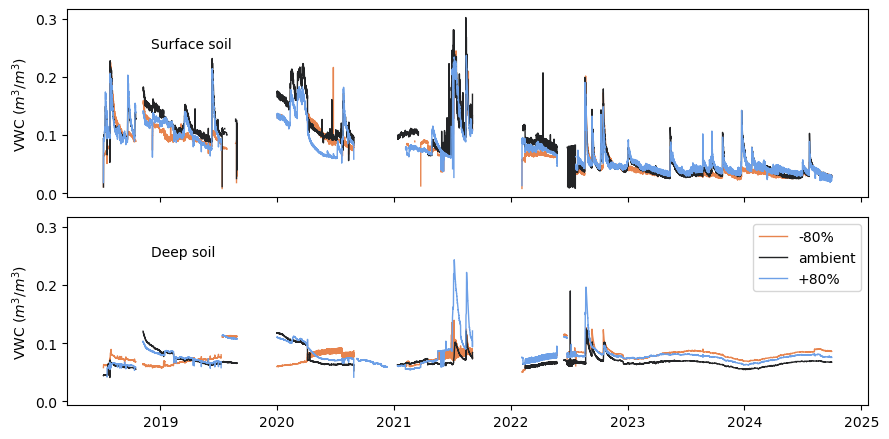

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(9,4.5), sharey=True, sharex=True)
ax[0].plot(trt_means.sh_drtmean, lw=1, color=p[0], label='-80%')
ax[0].plot(trt_means.sh_ambmean, lw=1, color=p[1], label='ambient')
ax[0].plot(trt_means.sh_irrmean, lw=1, color=p[2], label='+80%')

ax[1].plot(trt_means.dp_drtmean, lw=1, color=p[0], label='-80%')
ax[1].plot(trt_means.dp_ambmean, lw=1, color=p[1], label='ambient')
ax[1].plot(trt_means.dp_irrmean, lw=1, color=p[2], label='+80%')
plt.legend()

#ax[0].set(xlabel=None)
ax[0].set(ylabel="VWC ($m^3/m^3$)")
ax[1].set(ylabel="VWC ($m^3/m^3$)")
xaxlab = pd.to_datetime('2018-12-01')
ax[0].text(xaxlab, 0.25, 'Surface soil' )
ax[1].text(xaxlab, 0.25, 'Deep soil' )
plt.tight_layout()

#plt.savefig(outpath + '/figs/sm_means_bydepth.png', dpi=300, facecolor='w')

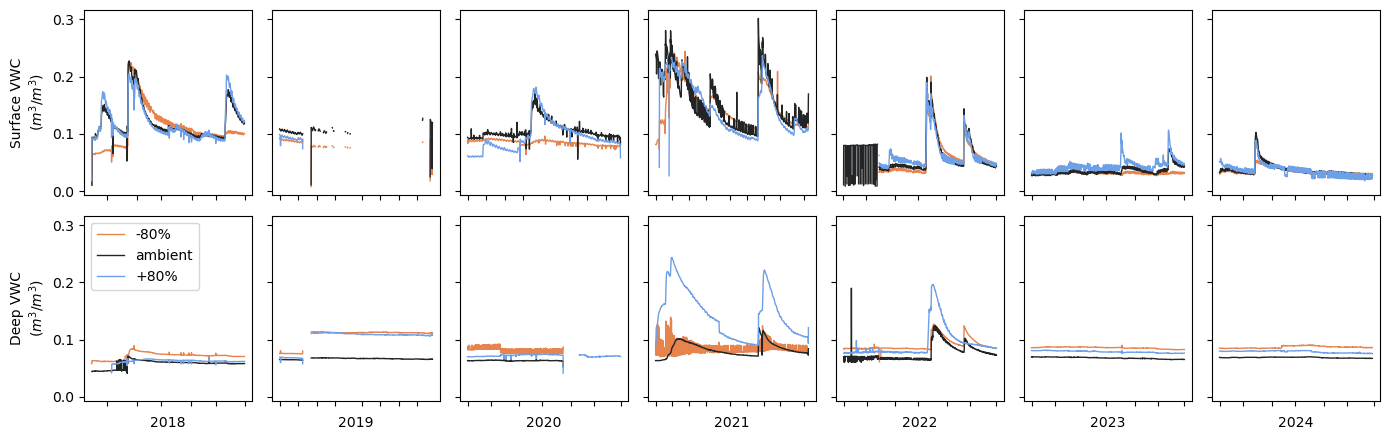

In [17]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(2, 7, figsize=(14,4.5), sharey=True, sharex=False)

for i, year in enumerate([2018,2019,2020,2021,2022,2023,2024]):
    yr = np.logical_and(trt_means.year==year, monsoon)
    ax[0,i].plot(trt_means.sh_drtmean[yr], lw=1, color=p[0], label='-80%')
    ax[0,i].plot(trt_means.sh_ambmean[yr], lw=1, color=p[1], label='ambient')
    ax[0,i].plot(trt_means.sh_irrmean[yr], lw=1, color=p[2], label='+80%')
    
    ax[1,i].plot(trt_means.dp_drtmean[yr], lw=1, color=p[0], label='-80%')
    ax[1,i].plot(trt_means.dp_ambmean[yr], lw=1, color=p[1], label='ambient')
    ax[1,i].plot(trt_means.dp_irrmean[yr], lw=1, color=p[2], label='+80%')
    ax[1,i].set_xticklabels([])
    ax[1,i].set_xlabel(year)

fig.autofmt_xdate()
ax[1,0].legend(loc='upper left')

ax[1,0].fmt_xdata = mdates.DateFormatter('%Y-%m')

ax[0,0].set(ylabel="Surface VWC\n($m^3/m^3$)")
ax[1,0].set(ylabel="Deep VWC\n($m^3/m^3$)")

plt.tight_layout()

#plt.savefig(outpath + '/figs/sm_means_bydepth_JAS.png', dpi=300, facecolor='w')

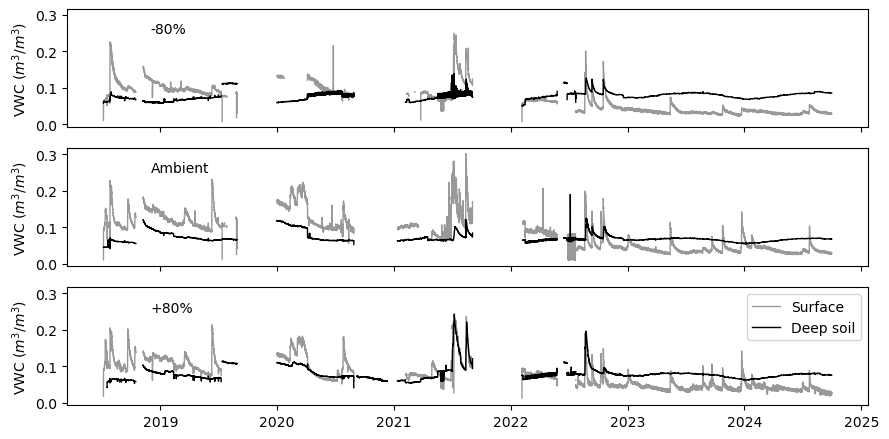

In [18]:

fig, ax = plt.subplots(3, 1, figsize=(9,4.5), sharey=True, sharex=True)
ax[0].plot(trt_means.sh_drtmean, lw=1, color='0.6', label='Surface')
ax[0].plot(trt_means.dp_drtmean, lw=1, color='k', label='Deep soil')

ax[1].plot(trt_means.sh_ambmean, lw=1, color='0.6', label='Surface')
ax[1].plot(trt_means.dp_ambmean, lw=1, color='k', label='Deep soil')

ax[2].plot(trt_means.sh_irrmean, lw=1, color='0.6', label='Surface')
ax[2].plot(trt_means.dp_irrmean, lw=1, color='k', label='Deep soil')
plt.legend()

#ax[0].set(xlabel=None)
ax[0].set(ylabel="VWC ($m^3/m^3$)")
ax[1].set(ylabel="VWC ($m^3/m^3$)")
ax[2].set(ylabel="VWC ($m^3/m^3$)")
xaxlab = pd.to_datetime('2018-12-01')
ax[0].text(xaxlab, 0.25, '-80%' )
ax[1].text(xaxlab, 0.25, 'Ambient' )
ax[2].text(xaxlab, 0.25, '+80%' )
plt.tight_layout()

#plt.savefig(outpath + '/figs/sm_means_bytrt.png', dpi=300, facecolor='w')

In [65]:
# Read in the "long" soil moisture dataframe - note that the datetime column has 
# duplicates, so shouldn't be parsed as an index
df_long = pd.read_csv(ready_path + '/sm_long_juntar.csv', parse_dates=['datetime'])
df_long.info()
df_long.head()
# Export
#df_long.to_csv(outpath + '/data/sm_long_new.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967760 entries, 0 to 1967759
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   variable   object        
 2   value      float64       
 3   depth      object        
 4   plotid     int64         
 5   n_trt      int64         
 6   ppt_trt    int64         
 7   month      int64         
 8   year       int64         
 9   Treatment  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 150.1+ MB


,datetime,variable,value,depth,plotid,n_trt,ppt_trt,month,year,Treatment
0,2018-07-06 00:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
1,2018-07-06 01:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
2,2018-07-06 02:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
3,2018-07-06 03:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
4,2018-07-06 04:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient


In [66]:
# Create a wider dataframe with columns for ppt treatments
df_pptcols = df_long.pivot_table(index=['datetime', 'plotid', 'depth'],columns='ppt_trt', values='value')
df_pptcols.columns = ['-80%', 'ambient', '+80%']
df_pptcols = df_pptcols.reset_index()
# Sort values
df_pptcols = df_pptcols.sort_values(['plotid', 'depth', 'datetime'])
df_pptcols.tail()
# Month column
df_pptcols['month'] = df_pptcols.datetime.dt.month
#df_pptcols['week'] = df_pptcols.datetime.dt.week

/var/folders/wj/7fgjbm815wl1ht4n6vcz7jlr0000gn/T/ipykernel_28929/3478488293.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a3.set_xticklabels(labels=labels,rotation=45);


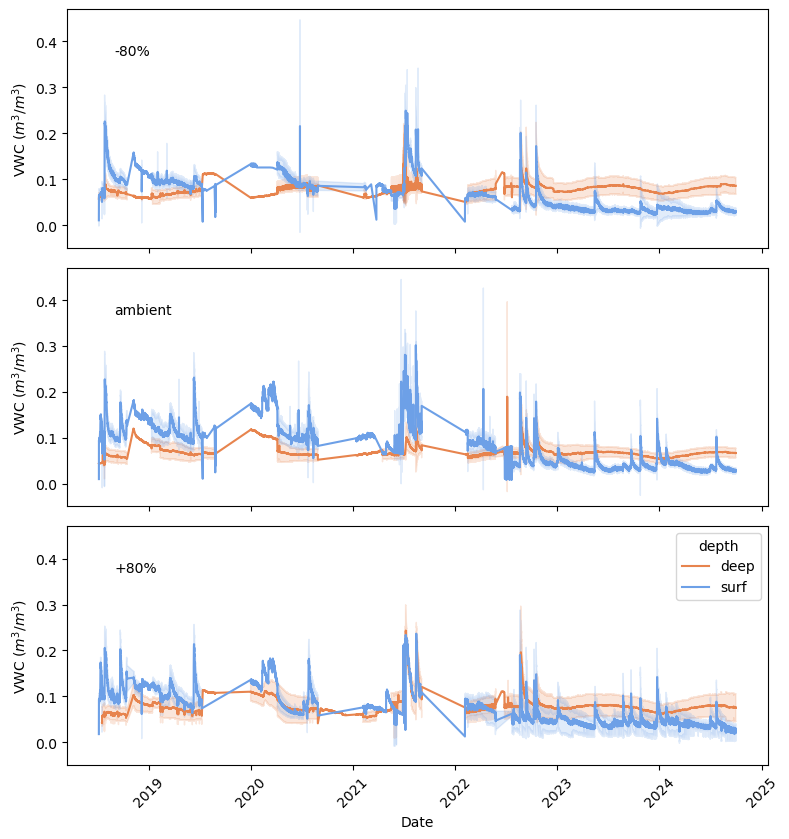

In [67]:
p2 = sns.diverging_palette(30, 250, l=65, center="dark", n=2)
sns.set_palette(p2)
#sns.set_palette("icefire_r", 3, .75)
fig, ax = plt.subplots(3, 1, figsize=(8,8.5), sharey=True, sharex=True)
a1 = sns.lineplot(data=df_pptcols, ax=ax[0], x='datetime', y='-80%',
                  hue="depth", errorbar='sd', legend=False)
a2 = sns.lineplot(data=df_pptcols, ax=ax[1], x="datetime", y='ambient',
                  hue="depth", errorbar='sd', legend=False)
a3 = sns.lineplot(data=df_pptcols, ax=ax[2], x="datetime", y='+80%',
                  hue="depth", errorbar='sd', legend=True)

a1.set(xlabel=None)
a1.set(ylabel="VWC ($m^3/m^3$)")
a2.set(ylabel="VWC ($m^3/m^3$)")
a3.set(ylabel="VWC ($m^3/m^3$)")
a3.set(xlabel='Date')
a2.set(xlabel=None)
xaxlab = pd.to_datetime('2018-8-30')
a1.text(xaxlab, 0.37, '-80%' )
a2.text(xaxlab, 0.37, 'ambient' )
a3.text(xaxlab, 0.37, '+80%' )
labels = a3.get_xticklabels()
a3.set_xticklabels(labels=labels,rotation=45);
plt.tight_layout()

#plt.savefig(outpath + '/figs/sm_3panel.png', dpi=300, facecolor='w')

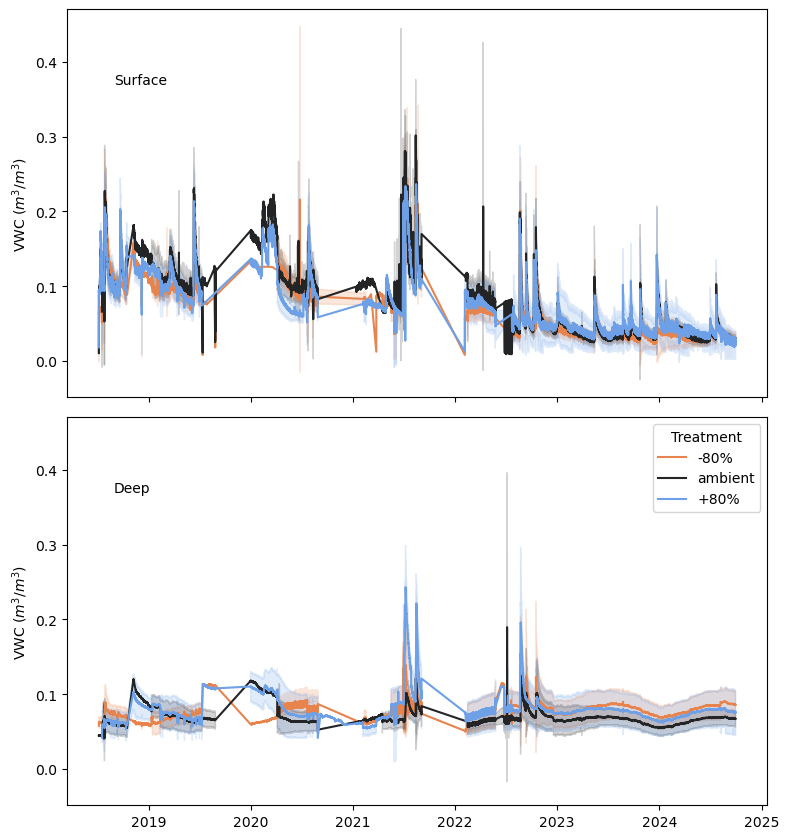

In [68]:
# Use long dataset - plot mean and CI of surface and deep water by treatment
#sns.set_palette([p[1],p[2],p[0]])
sns.set_palette(p)

fig, ax = plt.subplots(2, 1, figsize=(8,8.5), sharey=True, sharex=True)
a1 = sns.lineplot(data=df_long[df_long.depth=='surf'], ax=ax[0], x='datetime', y='value',
                  hue="Treatment", errorbar='sd', legend=False, hue_order=['-80%', 'ambient','+80%'])
a2 = sns.lineplot(data=df_long[df_long.depth=='deep'], ax=ax[1], x="datetime", y='value',
                  hue="Treatment", errorbar='sd', legend=True, hue_order=['-80%', 'ambient','+80%'])
#a3 = sns.lineplot(data=df_long, ax=ax[2], x="datetime", y='+80%',
#                  hue="depth", errorbar='sd', legend=True)

a1.set(xlabel=None)
a1.set(ylabel="VWC ($m^3/m^3$)")
a2.set(ylabel="VWC ($m^3/m^3$)")
#a3.set(ylabel="VWC ($m^3/m^3$)")
#a3.set(xlabel='Date')
a2.set(xlabel=None)
xaxlab = pd.to_datetime('2018-8-30')
a1.text(xaxlab, 0.37, 'Surface' )
a2.text(xaxlab, 0.37, 'Deep' )
#a3.text(xaxlab, 0.37, '+80%' )
plt.tight_layout()


Text(0.25, 0.25, 'Deep soil')

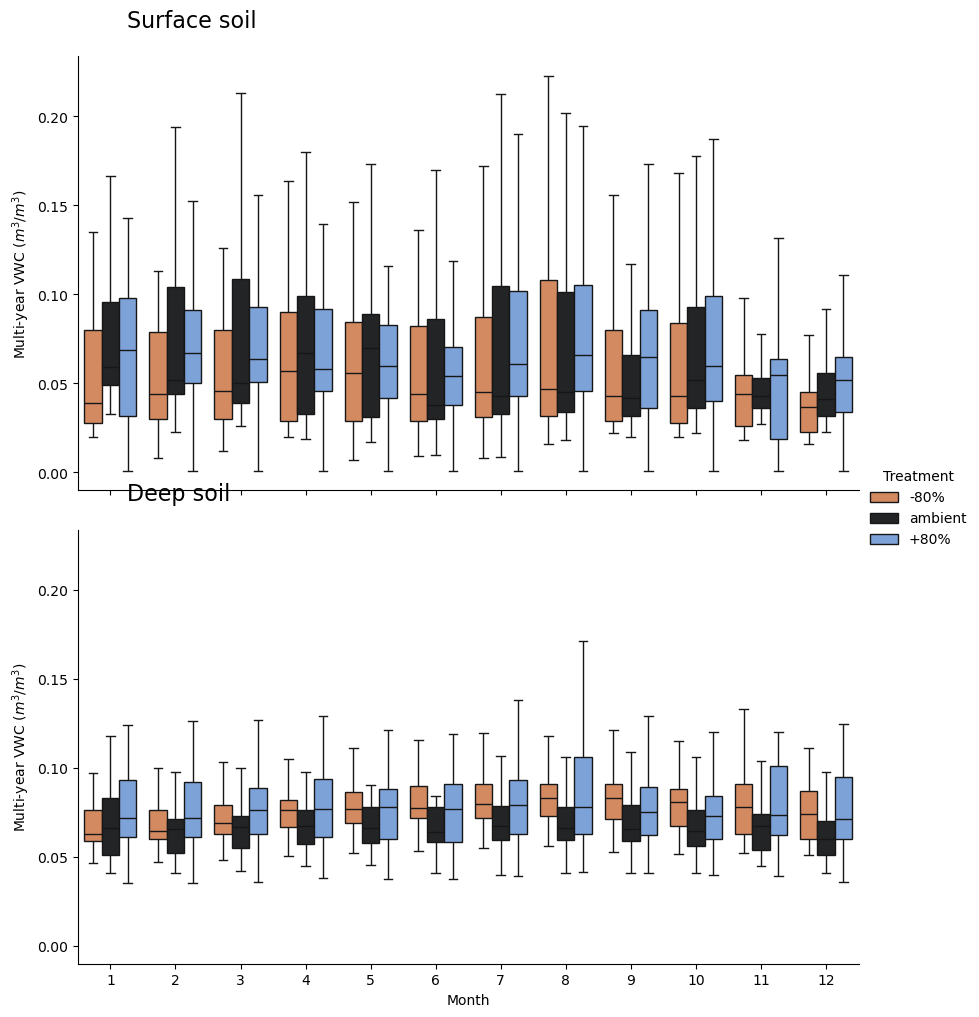

In [69]:
# Boxplots showing distribution in each month across all years
g = sns.catplot(data=df_long, x='month', y='value', hue='Treatment', row='depth', kind='box',
                errorbar='sd', legend=True, showfliers=False, aspect=1.75,
                hue_order=['-80%', 'ambient','+80%'], row_order=['surf','deep'])
g.set(ylabel="Multi-year VWC ($m^3/m^3$)", xlabel='Month')
g.set_titles('')
g.axes[0,0].text(0.25, 0.25,'Surface soil', fontsize=16)
g.axes[1,0].text(0.25, 0.25,'Deep soil', fontsize=16)

#plt.savefig(outpath + '/figs/sm_boxp_depth_trt.png', dpi=300, facecolor='w')

In [70]:
df_long.head()

,datetime,variable,value,depth,plotid,n_trt,ppt_trt,month,year,Treatment
0,2018-07-06 00:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
1,2018-07-06 01:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
2,2018-07-06 02:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
3,2018-07-06 03:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
4,2018-07-06 04:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient


In [71]:
df_pptcols.head()

,datetime,plotid,depth,-80%,ambient,+80%,month
21,2018-07-06 18:00:00,101,deep,NaN,0.04409,NaN,7
29,2018-07-06 19:00:00,101,deep,NaN,0.04405,NaN,7
37,2018-07-06 20:00:00,101,deep,NaN,0.04451,NaN,7
45,2018-07-06 21:00:00,101,deep,NaN,0.04459,NaN,7
53,2018-07-06 22:00:00,101,deep,NaN,0.04449,NaN,7


In [72]:
# Get a growing season subset of the long dataframe
test = np.where((df_long.month > 6) & (df_long.month < 10))
df_long_gs = df_long.loc[test]
# Add day
df_long_gs['day'] = df_long_gs.datetime.dt.day
df_long_gs.head()

,datetime,variable,value,depth,plotid,n_trt,ppt_trt,month,year,Treatment,day
0,2018-07-06 00:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
1,2018-07-06 01:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
2,2018-07-06 02:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
3,2018-07-06 03:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
4,2018-07-06 04:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6


## Combined fig

/var/folders/wj/7fgjbm815wl1ht4n6vcz7jlr0000gn/T/ipykernel_28929/969987605.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a13.set_xticklabels((7, 8, 9), rotation=0)


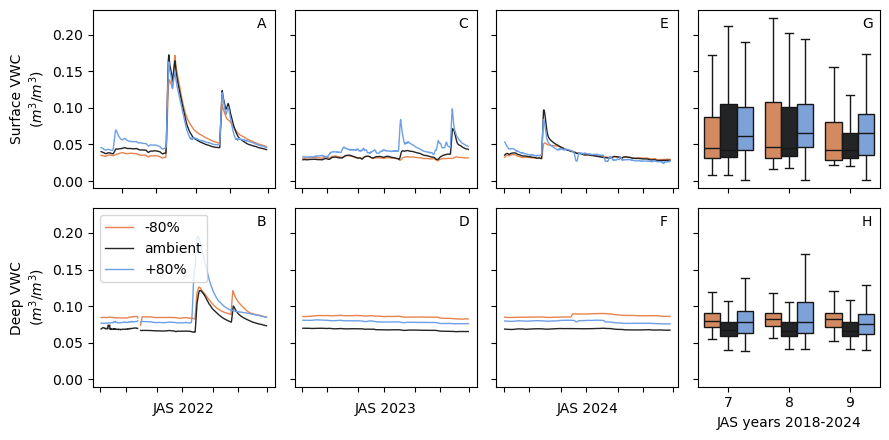

In [73]:

#sns.set_palette("icefire_r", 3, .75)
fig, ax = plt.subplots(2, 4, figsize=(9,4.5), sharey=True, sharex=False)
top = ['A','C','E']
bott = ['B', 'D','F']
for i, year in enumerate([2022,2023,2024]):
    yr = np.logical_and(trt_means.year==year, monsoon)
    ax[0,i].plot(trt_means.sh_drtmean[yr].rolling(24, center=True).mean(), lw=1, color=p[0], label='-80%')
    ax[0,i].plot(trt_means.sh_ambmean[yr].rolling(24, center=True).mean(), lw=1, color=p[1], label='ambient')
    ax[0,i].plot(trt_means.sh_irrmean[yr].rolling(24, center=True).mean(), lw=1, color=p[2], label='+80%')
    ax[0,i].text(0.9, 0.9, top[i], transform=ax[0,i].transAxes)
    ax[0,i].set_xticklabels([])
    
    ax[1,i].plot(trt_means.dp_drtmean[yr].rolling(24, center=True).mean(), lw=1, color=p[0], label='-80%')
    ax[1,i].plot(trt_means.dp_ambmean[yr].rolling(24, center=True).mean(), lw=1, color=p[1], label='ambient')
    ax[1,i].plot(trt_means.dp_irrmean[yr].rolling(24, center=True).mean(), lw=1, color=p[2], label='+80%')
    ax[1,i].text(0.9, 0.9, bott[i], transform=ax[1,i].transAxes)
    ax[1,i].set_xticklabels([])
    ax[1,i].set_xlabel('JAS ' + str(year))

    
#fig.autofmt_xdate()
#ax[1,0].fmt_xdata = mdates.DateFormatter('%Y-%m')

a03 = sns.boxplot(data=df_long_gs[df_long_gs.depth=='surf'],
                x='month', y='value', hue='Treatment',
                showfliers=False, ax = ax[0,3],
                hue_order=['-80%', 'ambient','+80%'])
a13 = sns.boxplot(data=df_long_gs[df_long_gs.depth=='deep'],
                 x='month', y='value', hue='Treatment',
                showfliers=False, ax = ax[1,3],
                hue_order=['-80%', 'ambient','+80%'])
a03.text(0.9, 0.9, 'G', transform=a03.transAxes)
a13.text(0.9, 0.9, 'H', transform=a13.transAxes)

ax[1,0].legend(loc='upper left')


ax[0,0].set(ylabel="Surface VWC\n($m^3/m^3$)")
ax[1,0].set(ylabel="Deep VWC\n($m^3/m^3$)")

a03.get_legend().remove()
a13.get_legend().remove()
a03.set_xlabel('')
a03.set_xticklabels([])
a13.set_xlabel('JAS years 2018-2024')
a13.set_xticklabels((7, 8, 9), rotation=0)
#a13.set_xticklabels([])
a03.set_ylabel('')
a13.set_ylabel('')

plt.tight_layout()

#plt.savefig(outpath + '/figs/sm_means_bydepth_JAS_and_boxp.png', dpi=300, facecolor='w')

Text(0, 0.5, 'VWC ($m^3/m^3$)')

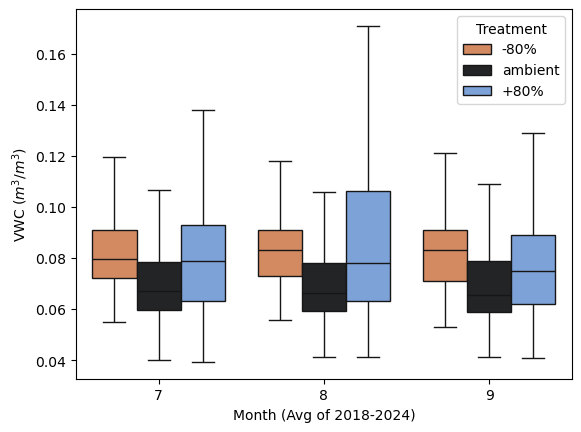

In [74]:
#fig, ax = plt.subplots(2, 4, figsize=(9,4.5), sharey=True, sharex=False)

ax = sns.boxplot(data=df_long_gs[df_long_gs.depth=='deep'],
                 x='month', y='value', hue='Treatment',
                showfliers=False,
                hue_order=['-80%', 'ambient','+80%'])

ax.set_xlabel('Month (Avg of 2018-2024)')
ax.set_ylabel('VWC ($m^3/m^3$)')

#ax.text(0.9, 0.9, 'H', transform=a13.transAxes)

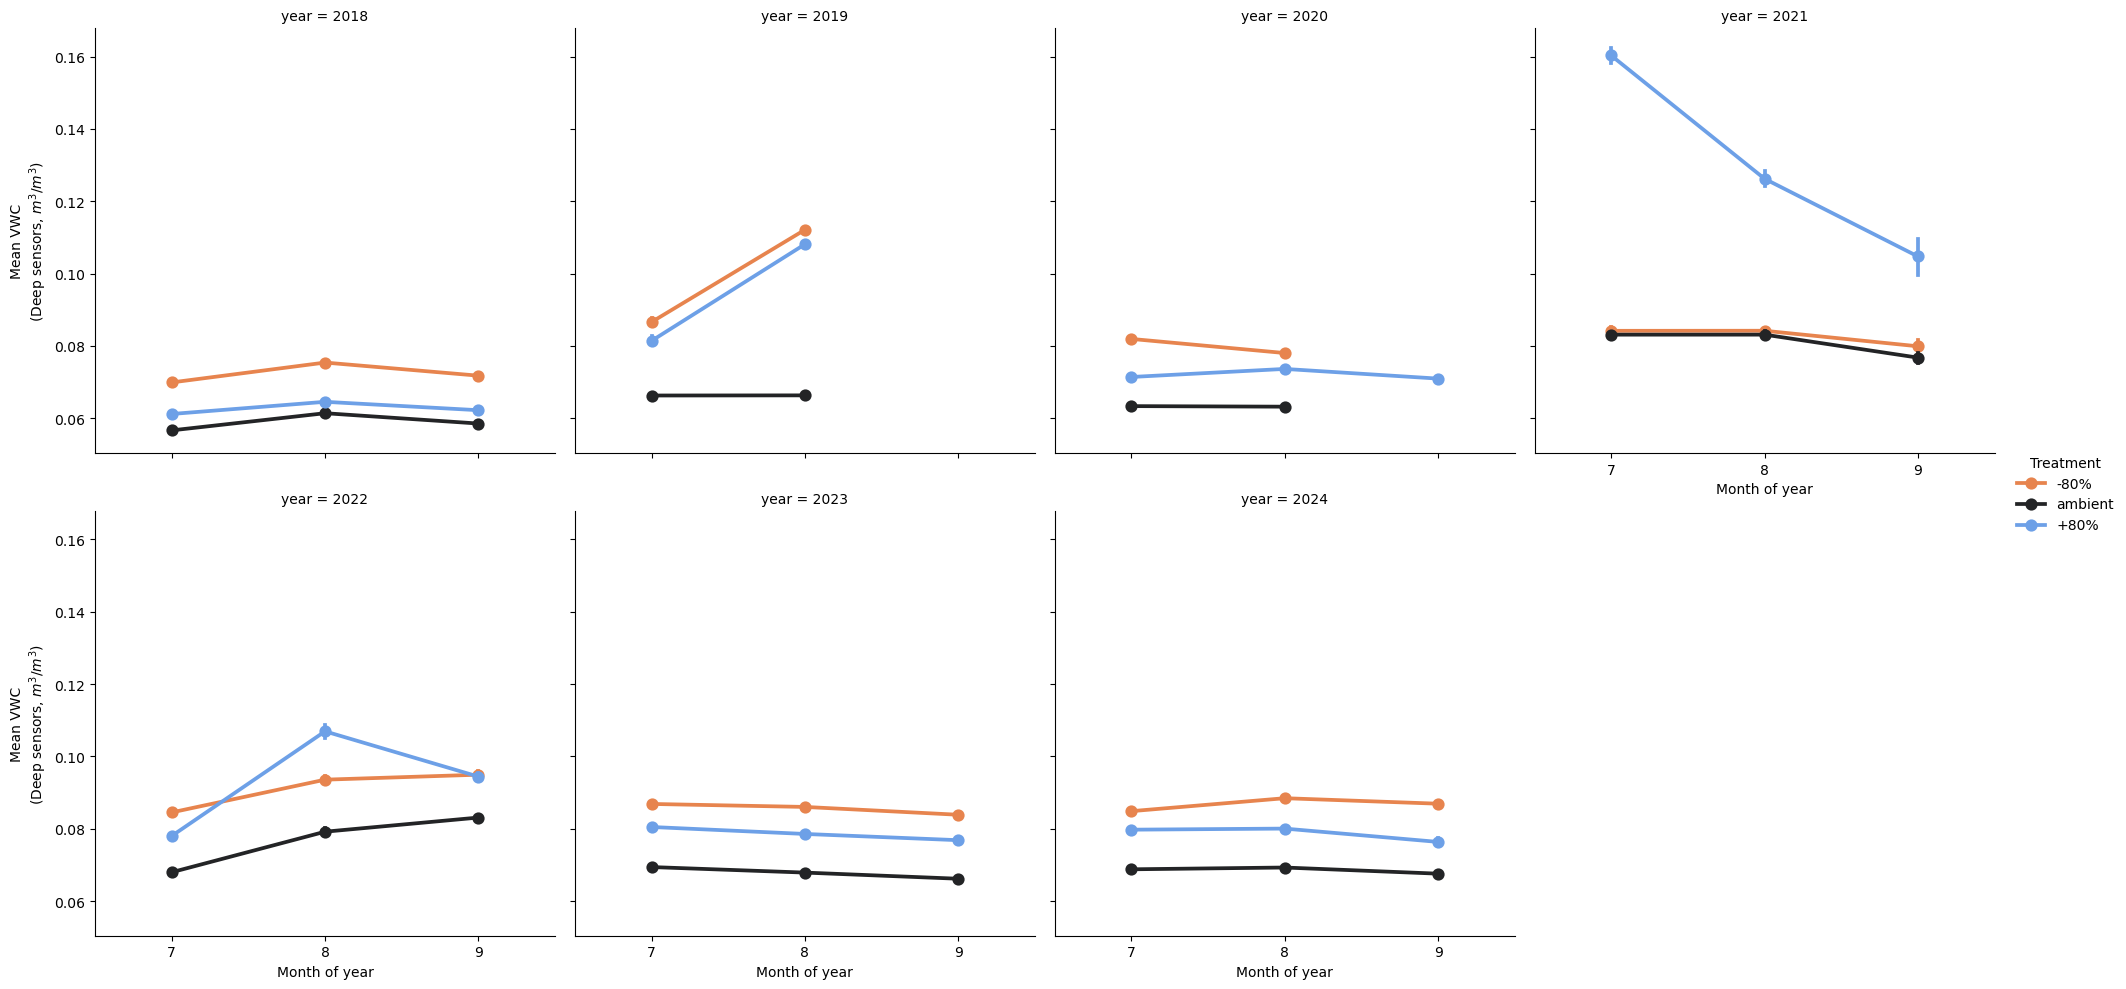

In [75]:
fig = sns.catplot(data=df_long_gs[df_long_gs.depth=='deep'],
                 x='month', y='value', hue='Treatment', col='year', kind='point',
                hue_order=['-80%', 'ambient','+80%'], col_wrap=4)

fig.set_xlabels('Month of year')
fig.set_ylabels('Mean VWC\n(Deep sensors, $m^3/m^3$)')

#plt.savefig(outpath + '/figs/multi-year-gs-monthly-absVWC.jpg', dpi=400, facecolor='w')


Text(0, 0.5, 'Growing season average VWC\n(JAS, $m^3/m^3$)')

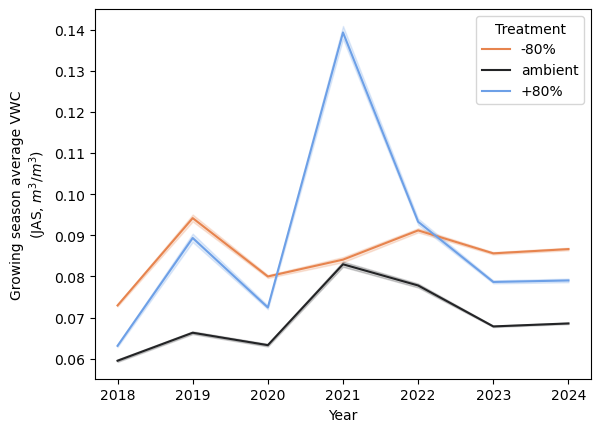

In [77]:

ax = sns.lineplot(data=df_long_gs[df_long_gs.depth=='deep'],
                 x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax.set_xlabel('Year')
ax.set_ylabel('Growing season average VWC\n(JAS, $m^3/m^3$)')

#plt.savefig(outpath + '/figs/fig4_absVWC.jpg', dpi=400, facecolor='w')

Text(2018.2, 0.155, 'Deep soil')

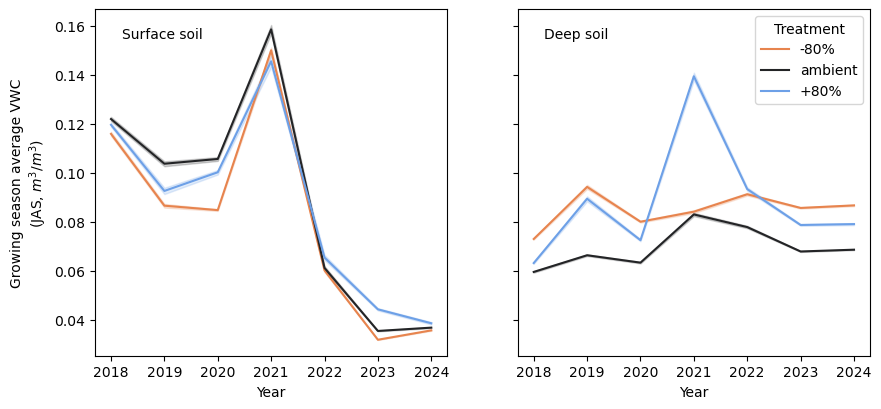

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10,4.5), sharey=True, sharex=False)

ax0 = sns.lineplot(data=df_long_gs[df_long_gs.depth=='surf'],
                ax = ax[0], legend=False,
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax0.set_xlabel('Year')
ax0.set_ylabel('Growing season average VWC\n(JAS, $m^3/m^3$)')
ax0.text(2018.2, 0.155, 'Surface soil' )

ax1 = sns.lineplot(data=df_long_gs[df_long_gs.depth=='deep'],
                ax = ax[1],
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax1.set_xlabel('Year')
ax1.text(2018.2, 0.155, 'Deep soil' )

#plt.savefig(outpath + '/figs/fig4_absVWC_2layer.jpg', dpi=400, facecolor='w')

In [79]:
# Group data by day, depth, and treatment and create a daily dataset
dailym = df_long_gs.groupby(['year', 'month', 'day', 'depth', 'Treatment'])['value'].mean().reset_index()
# Boolean for values above sm threshold
dailym['thresh1'] = dailym.value > 0.08
# Add a date column
dailym['datetime'] =  pd.to_datetime(dailym.loc[:,['year', 'month', 'day']])
# Count number of days per month above threshold
gs_thresh1 = dailym.groupby(['year', 'month', 'depth', 'Treatment'])['thresh1'].sum().reset_index()

print(dailym.head())
print(gs_thresh1.head())

   year  month  day depth Treatment     value  thresh1   datetime
0  2018      7    6  deep      +80%       NaN    False 2018-07-06
1  2018      7    6  deep      -80%  0.061909    False 2018-07-06
2  2018      7    6  deep   ambient  0.044357    False 2018-07-06
3  2018      7    6  surf      +80%  0.085646     True 2018-07-06
4  2018      7    6  surf      -80%  0.056771    False 2018-07-06
   year  month depth Treatment  thresh1
0  2018      7  deep      +80%        0
1  2018      7  deep      -80%        4
2  2018      7  deep   ambient        0
3  2018      7  surf      +80%       26
4  2018      7  surf      -80%        5


Text(0, 0.5, 'Days above threshold')

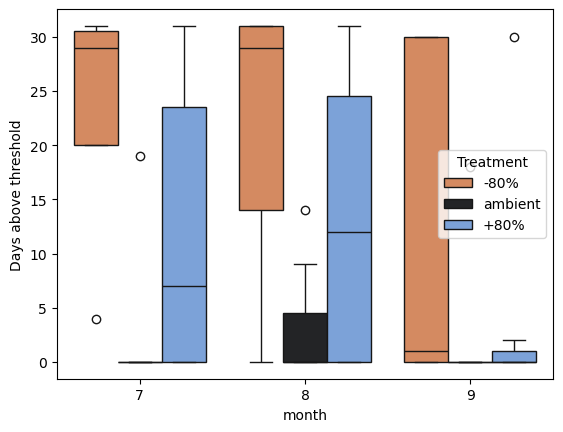

In [80]:

# Plot boxplots of days above the threshold for all years
a1 = sns.boxplot(data=gs_thresh1[gs_thresh1.depth=='deep'], x='month', y='thresh1', hue='Treatment',
                hue_order=['-80%', 'ambient','+80%'])
a1.set_ylabel('Days above threshold')


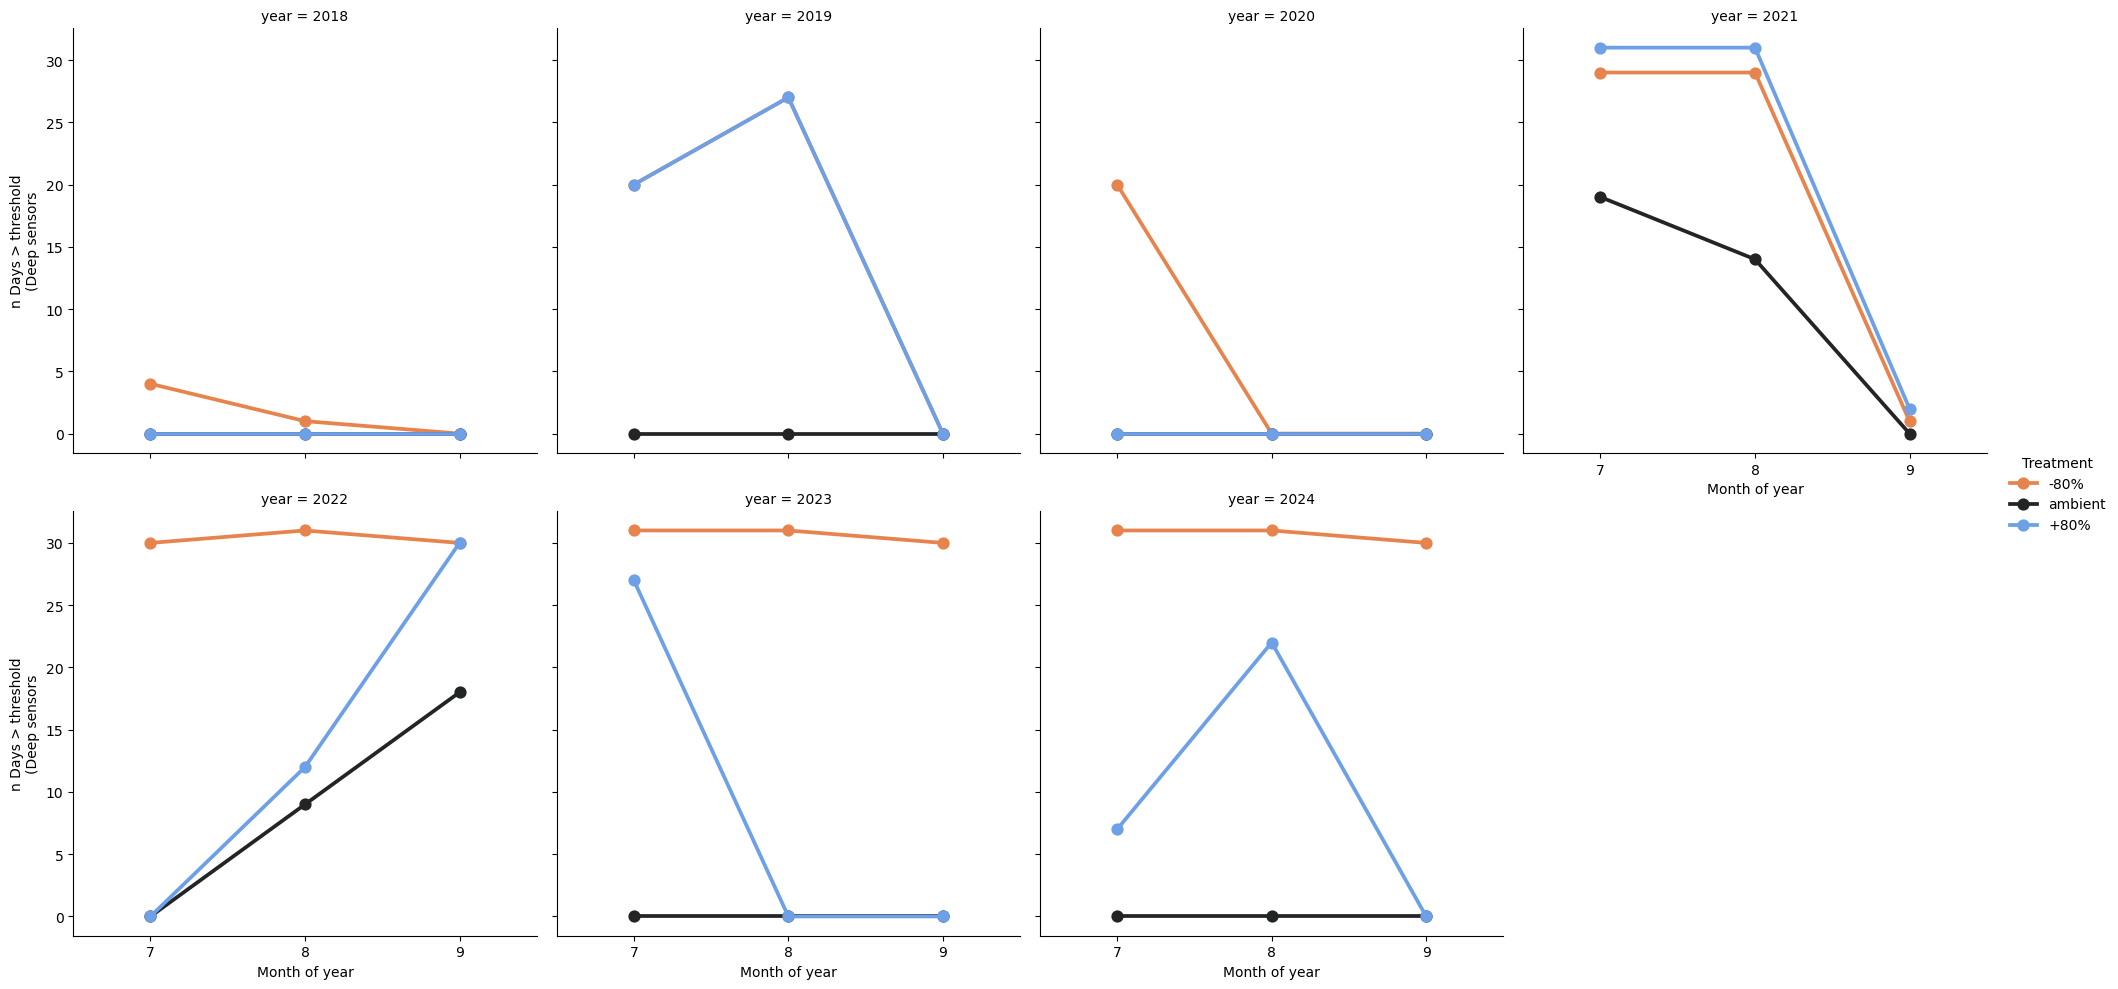

In [81]:
fig = sns.catplot(data=gs_thresh1[gs_thresh1.depth=='deep'],
                 x='month', y='thresh1', hue='Treatment', col='year', kind='point',
                hue_order=['-80%', 'ambient','+80%'], col_wrap=4)

fig.set_xlabels('Month of year')
fig.set_ylabels('n Days > threshold\n(Deep sensors')

Text(0, 0.5, 'n Growing Season Days > threshold\n(JAS)')

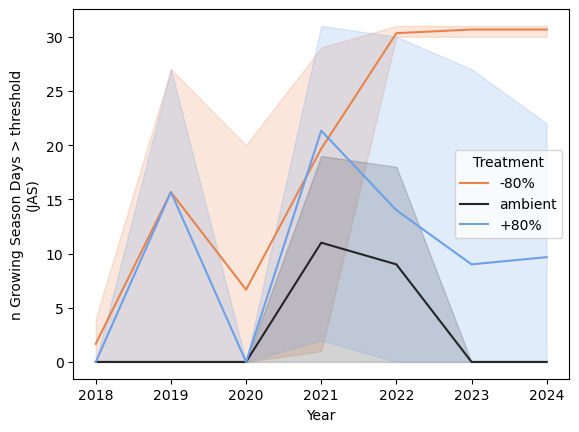

In [82]:
ax = sns.lineplot(data=gs_thresh1[gs_thresh1.depth=='deep'],
                 x='year', y='thresh1', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax.set_xlabel('Year')
ax.set_ylabel('n Growing Season Days > threshold\n(JAS)')

In [83]:
# Now look at the difference between deep and surface
# First pivot
one = dailym.pivot_table(index=['year', 'month', 'datetime', 'depth'],columns='Treatment', values='value').reset_index()
one['-80%'] = one['-80%'] - one.ambient
one['+80%'] = one['+80%'] - one.ambient
one['ambient'] = one.ambient - one.ambient
print(one.head())

gs_rel1 = one.melt(id_vars=['year', 'month', 'datetime', 'depth'])
print(gs_rel1.head())



Treatment  year  month   datetime depth      +80%      -80%  ambient
0          2018      7 2018-07-06  deep       NaN  0.017553      0.0
1          2018      7 2018-07-06  surf  0.003394 -0.025480      0.0
2          2018      7 2018-07-07  deep       NaN  0.018362      0.0
3          2018      7 2018-07-07  surf -0.001098 -0.027731      0.0
4          2018      7 2018-07-08  deep       NaN  0.018055      0.0
   year  month   datetime depth Treatment     value
0  2018      7 2018-07-06  deep      +80%       NaN
1  2018      7 2018-07-06  surf      +80%  0.003394
2  2018      7 2018-07-07  deep      +80%       NaN
3  2018      7 2018-07-07  surf      +80% -0.001098
4  2018      7 2018-07-08  deep      +80%       NaN


Text(0, 0.5, 'Difference from ambient')

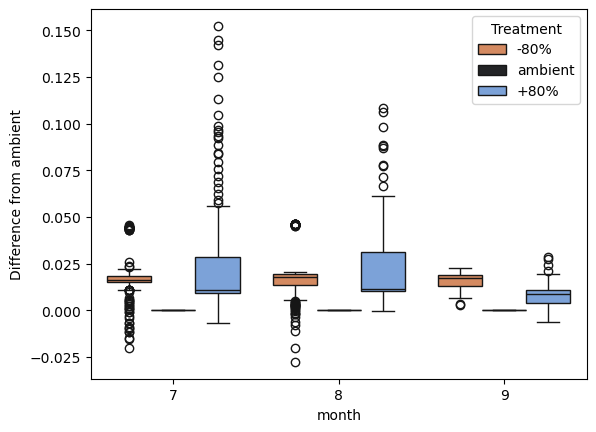

In [84]:
# Plot boxplots of the treatment difference from ambient
a1 = sns.boxplot(data=gs_rel1[gs_rel1.depth=='deep'], x='month', y='value', hue='Treatment',
                hue_order=['-80%', 'ambient','+80%'])
a1.set_ylabel('Difference from ambient')

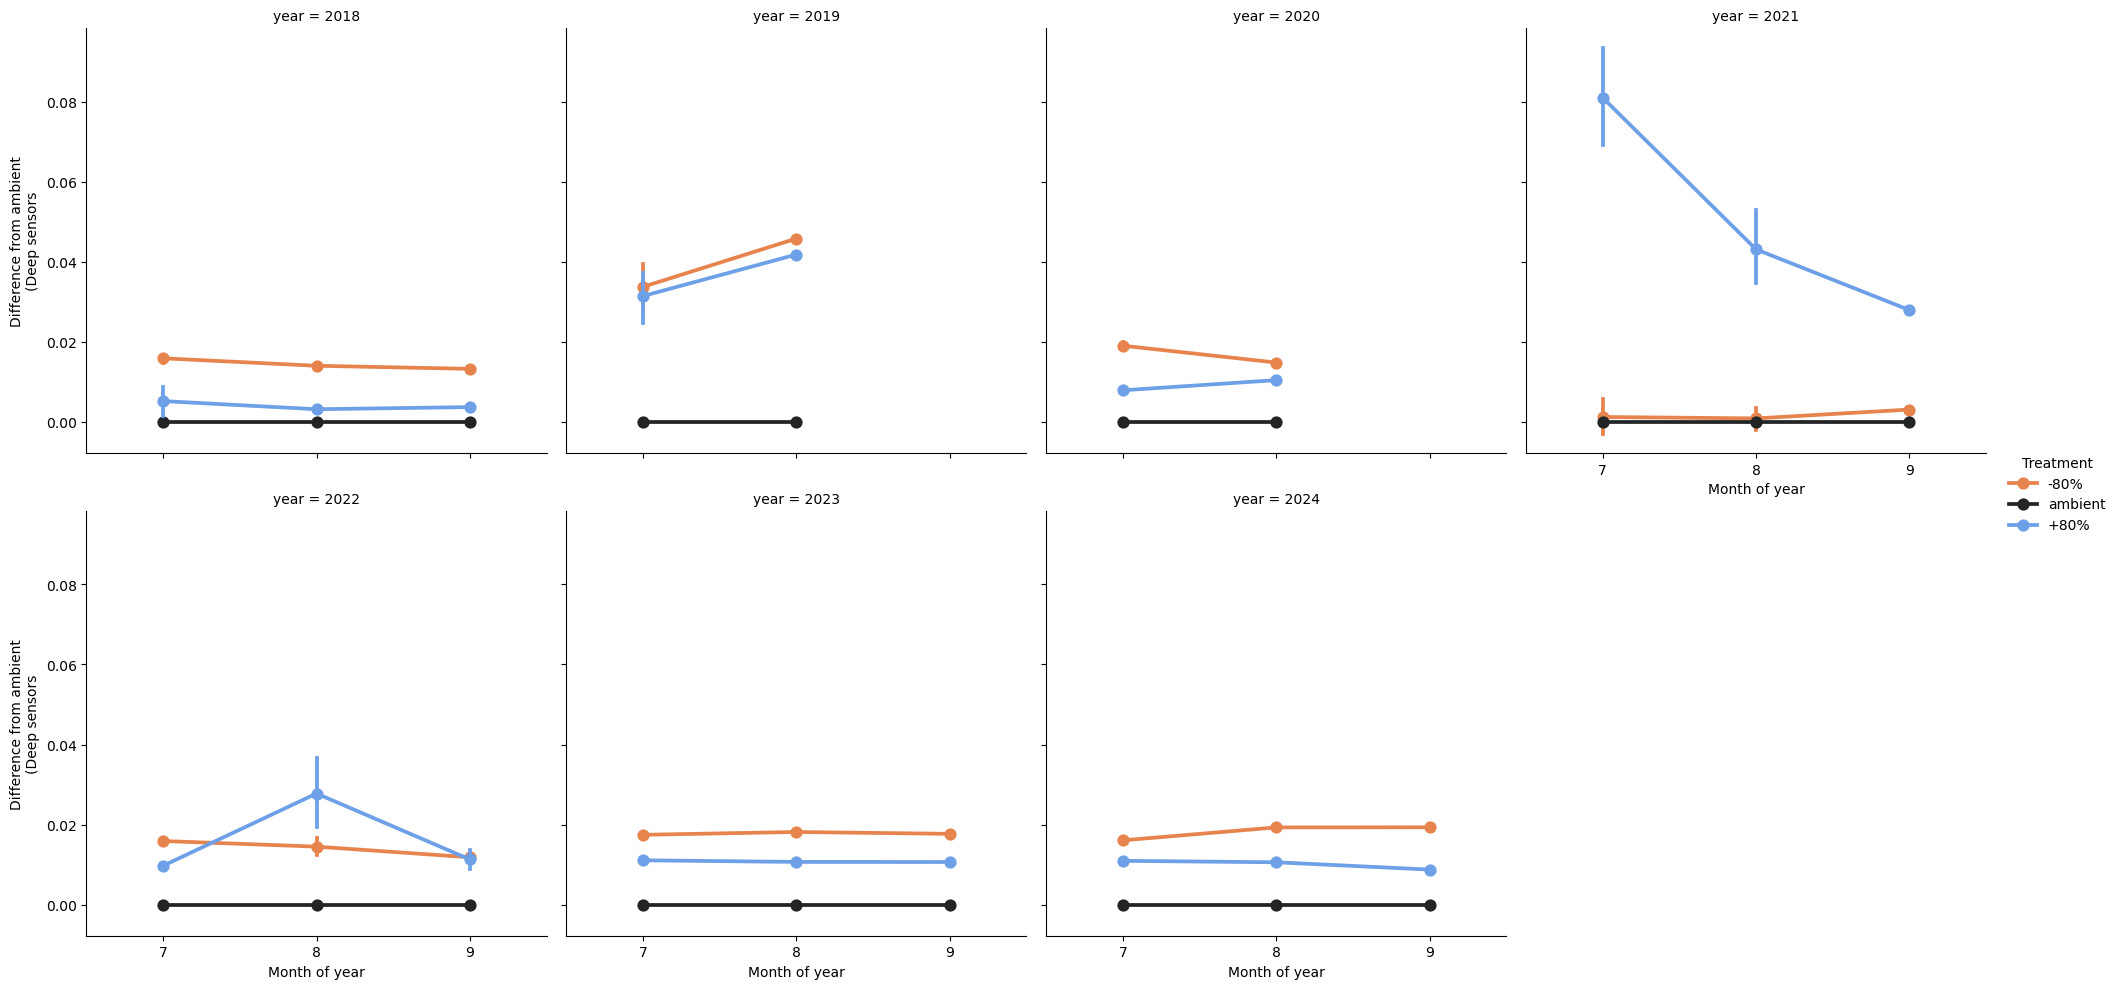

In [85]:
fig = sns.catplot(data=gs_rel1[gs_rel1.depth=='deep'],
                 x='month', y='value', hue='Treatment', col='year', kind='point',
                hue_order=['-80%', 'ambient','+80%'], col_wrap=4)

fig.set_xlabels('Month of year')
fig.set_ylabels('Difference from ambient\n(Deep sensors')

Text(0, 0.5, 'Growing season average VWC\nrelative to ambient (JAS, $m^3/m^3$)')

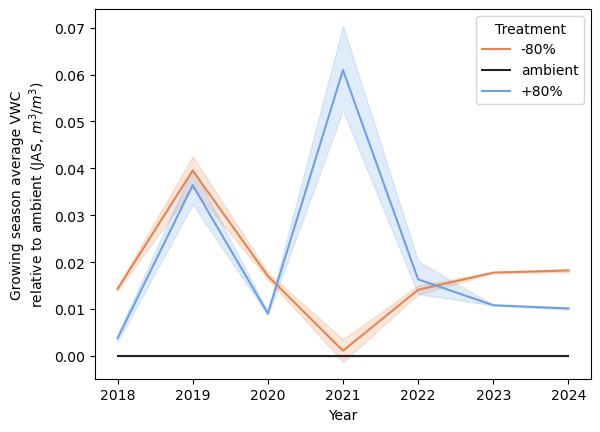

In [86]:
ax = sns.lineplot(data=gs_rel1[gs_rel1.depth=='deep'],
                 x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax.set_xlabel('Year')
ax.set_ylabel('Growing season average VWC\nrelative to ambient (JAS, $m^3/m^3$)')

#plt.savefig(outpath + '/figs/fig4_relVWC.jpg', dpi=400, facecolor='w')

In [87]:
# Now look at the difference between deep and surface
# First pivot
one = grp1.pivot_table(index=['year', 'month', 'day', 'Treatment'],columns='depth', values='value')
one['diffvwc'] = one.deep - one.surf
one['thresh2'] = one.diffvwc > 0.0
gs_thresh2 = one.groupby(['year', 'month', 'Treatment'])['thresh2'].sum().reset_index()
print(gs_thresh2.head())

# Plot boxplots of days above the threshold for all years
a1 = sns.boxplot(data=gs_thresh2, x='month', y='thresh2', hue='Treatment',
                hue_order=['-80%', 'ambient','+80%'])
a1.set_ylabel('Days above threshold')
#a1.set_ylim([0,10])


NameError: name 'grp1' is not defined